In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

%cd ..
from utils import *

/scratch2/jsalle/ObsScaling


In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval()
eval_result_path = "./eval_results/base_llm_post_training_eval.csv"
post_training_eval = pd.read_csv(eval_result_path)

# Merge 
base_llm_eval_with_post_training = pd.merge(base_llm_benchmark_eval, post_training_eval, on="Model")

mmlu_df = load_acc_mmlu_subtasks()
merged_eval = merge_mmlu_subtasks_with_init_df(base_llm_eval_with_post_training, mmlu_df)


SCALING_SETUP_KWARGS = {
    # Data preprocessing: PCA imputation and extraction
    **NONGSM_PCA_PREPROCESS_KWARGS,  # exclude GSM to avoid making the task trivial, e.g., using GSM to predict GSM
    
    # Non-lineariy: sigmoid with parametrized scale and shift
    "nonlinearity": "sigmoid", 

    # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
    "split_method": "cutoff_by_FLOPs (1E21)",
    "cutoff_threshold": 84,

    # Model families: include all we have evaled
    "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
    "df_groupby": 'Model Family',  # group markers by model family

    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
}

PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]   # plot scaling comparison w.r.t. model size, training FLOPs, and 3 PCs


## GSM8K eval metrics with CoT and self-consistency
GSM8K_METHOD_SCALING_COT_METRIC_MAP = {
    'gsm8k_5_exact_match,flexible-extract': "Naive + Greedy",
    'gsm8k_cot_8_exact_match,flexible-extract': "CoT + Greedy",
}

GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP = {
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': "CoT + 1 Sample",
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': "CoT + SC + 5 Samples",
}

GSM8K_METHOD_SCALING_ORIG_METRIC_MAP = {
    **GSM8K_METHOD_SCALING_COT_METRIC_MAP,
    **GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP,
    'difference': 'CoT - Naive'
}

GSM8K_COT_SCALING_METRICS = list(GSM8K_METHOD_SCALING_COT_METRIC_MAP.keys())
GSM8K_SELFCONS_SCALING_METRICS = list(GSM8K_METHOD_SCALING_SELFCONS_METRIC_MAP.keys())

GSM8K_METHOD_SCALING_METRICS = [
    'gsm8k_5_exact_match,flexible-extract',
    'gsm8k_cot_8_exact_match,flexible-extract',
    # 'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract',
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract',
]

color_palette = sns.color_palette()

GSM8K_METHOD_SCALING_COLOR_MAP = {
    'gsm8k_5_exact_match,flexible-extract': color_palette[1],
    'gsm8k_cot_8_exact_match,flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,score-first-flexible-extract': color_palette[0],
    'gsm8k_cot_self_consistency_8_exact_match,maj@5-flexible-extract': color_palette[2],
    'difference': color_palette[3],
}


GSM8K_SETUP_SPECIFIC_KWARGS = {}
for e in GSM8K_METHOD_SCALING_METRICS:
    GSM8K_SETUP_SPECIFIC_KWARGS[e] = {
        "plot_adjust_kwargs": {"title": GSM8K_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
    }

    if e != "gsm8k_5_exact_match,flexible-extract":
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["plot_adjust_kwargs"].update({"ylim": [-0.03, 0.97]})
    if e in ["gsm8k_5_exact_match,flexible-extract"]:
        GSM8K_SETUP_SPECIFIC_KWARGS[e]["grace_range_ratios"] = [0.05, 0.12]

Difference: gsm8k_cot_8_exact_match,flexible-extract - gsm8k_5_exact_match,flexible-extract


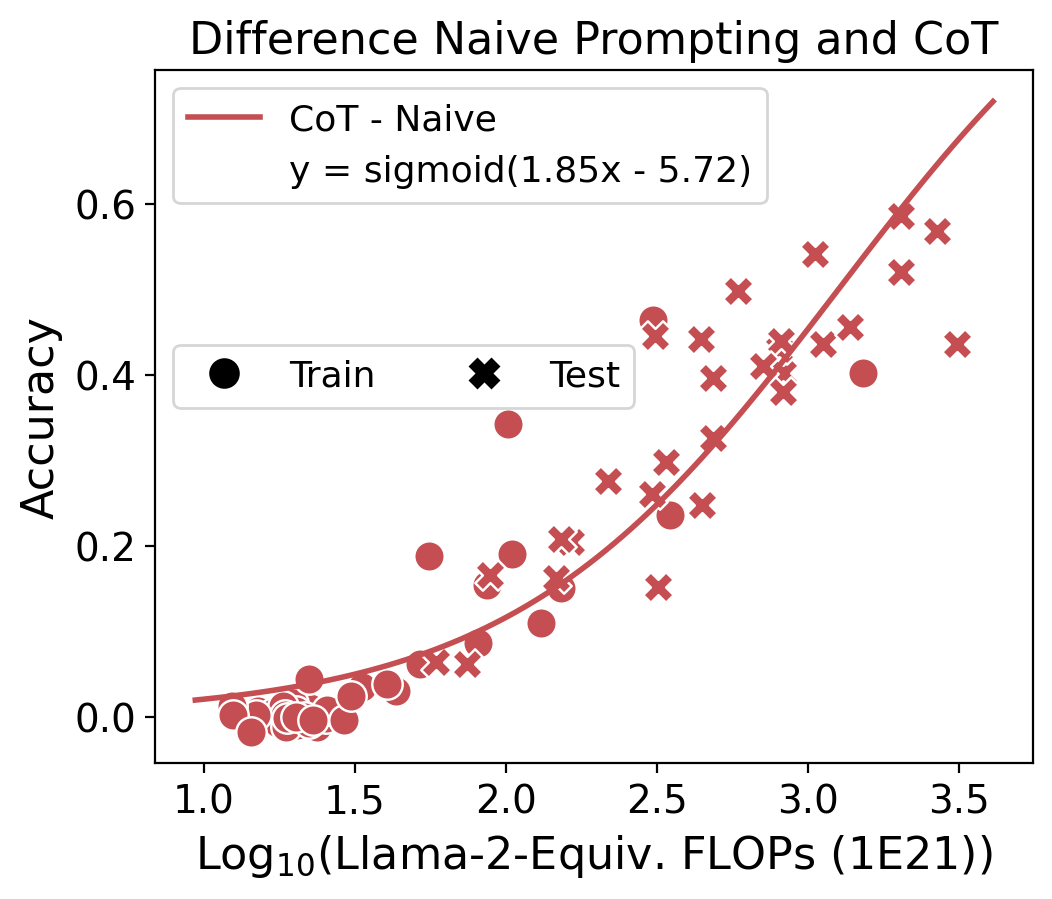

In [4]:
metric_for_difference = [
    'gsm8k_cot_8_exact_match,flexible-extract', # CoT
    'gsm8k_5_exact_match,flexible-extract', # Naive
]

fig, fit_results = plot_scaling_comparison_multi_metrics(
    base_llm_eval_with_post_training, 
    y_metric_list=['difference'], 
    metrics_for_difference=metric_for_difference,
    x_metrics_list=[PC_METRIC_NUM_3], 
    analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
    y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
    ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, 
    ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
    plot_title="Difference Naive Prompting and CoT"
)

Difference: bbh_cot_fewshot_boolean_expressions_3_exact_match,flexible-extract,norm - bbh_fewshot_boolean_expressions_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_causal_judgement_3_exact_match,flexible-extract,norm - bbh_fewshot_causal_judgement_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_date_understanding_3_exact_match,flexible-extract,norm - bbh_fewshot_date_understanding_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_disambiguation_qa_3_exact_match,flexible-extract,norm - bbh_fewshot_disambiguation_qa_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_dyck_languages_3_exact_match,flexible-extract,norm - bbh_fewshot_dyck_languages_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_formal_fallacies_3_exact_match,flexible-extract,norm - bbh_fewshot_formal_fallacies_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_geometric_shapes_3_exact_match,flexible-extract,norm - bbh_fewshot_geometric

/scratch2/jsalle/ObsScaling/utils/plot.py:835: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(5.5 * len(x_metrics_list), 4.5))


Difference: bbh_cot_fewshot_sports_understanding_3_exact_match,flexible-extract,norm - bbh_fewshot_sports_understanding_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_temporal_sequences_3_exact_match,flexible-extract,norm - bbh_fewshot_temporal_sequences_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_tracking_shuffled_objects_five_objects_3_exact_match,flexible-extract,norm - bbh_fewshot_tracking_shuffled_objects_five_objects_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_tracking_shuffled_objects_seven_objects_3_exact_match,flexible-extract,norm - bbh_fewshot_tracking_shuffled_objects_seven_objects_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_tracking_shuffled_objects_three_objects_3_exact_match,flexible-extract,norm - bbh_fewshot_tracking_shuffled_objects_three_objects_3_exact_match,flexible-extract,norm
Difference: bbh_cot_fewshot_web_of_lies_3_exact_match,flexible-extract,norm - bbh_fewshot_web_of_lies_3_exact_ma

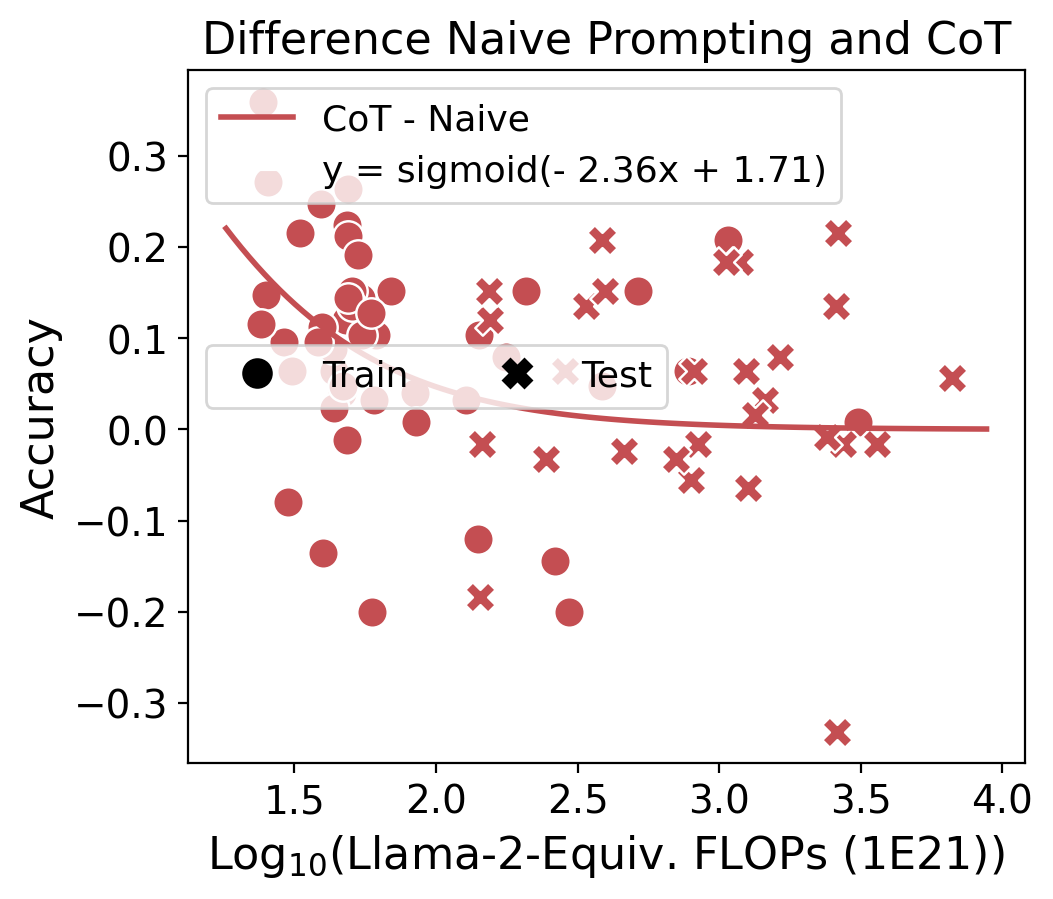

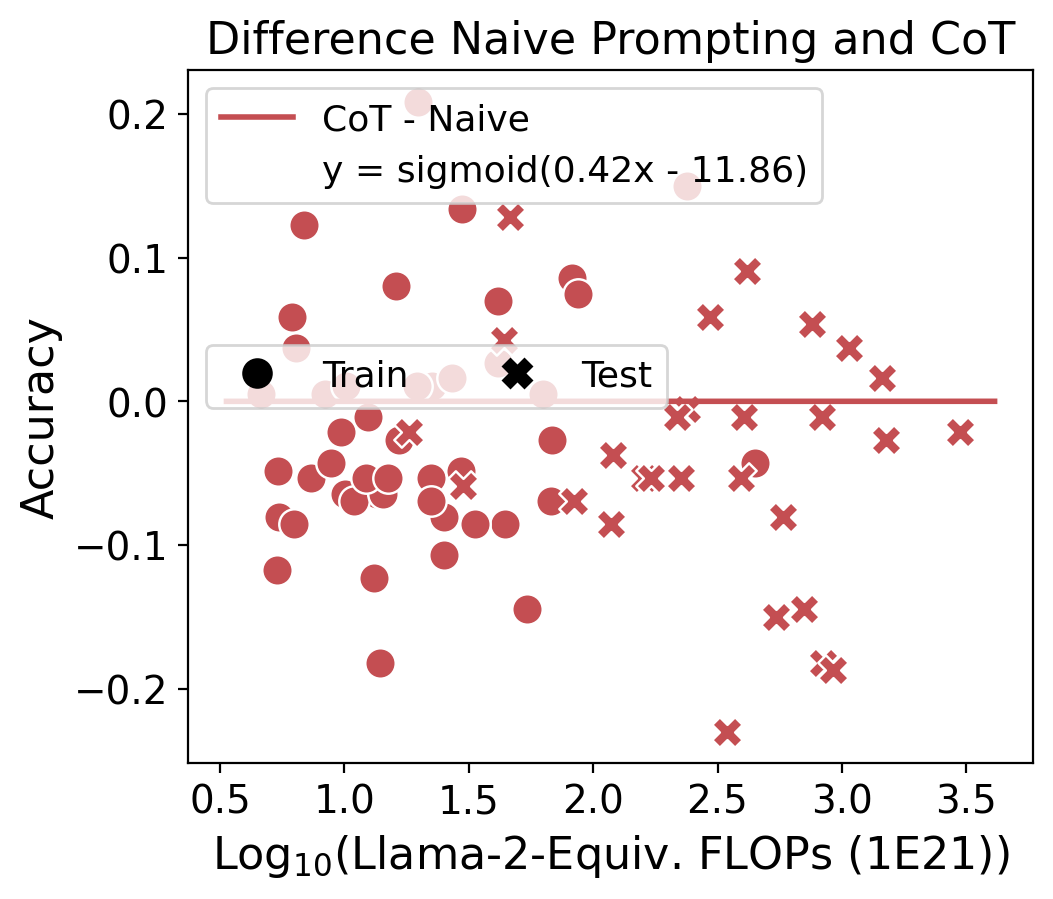

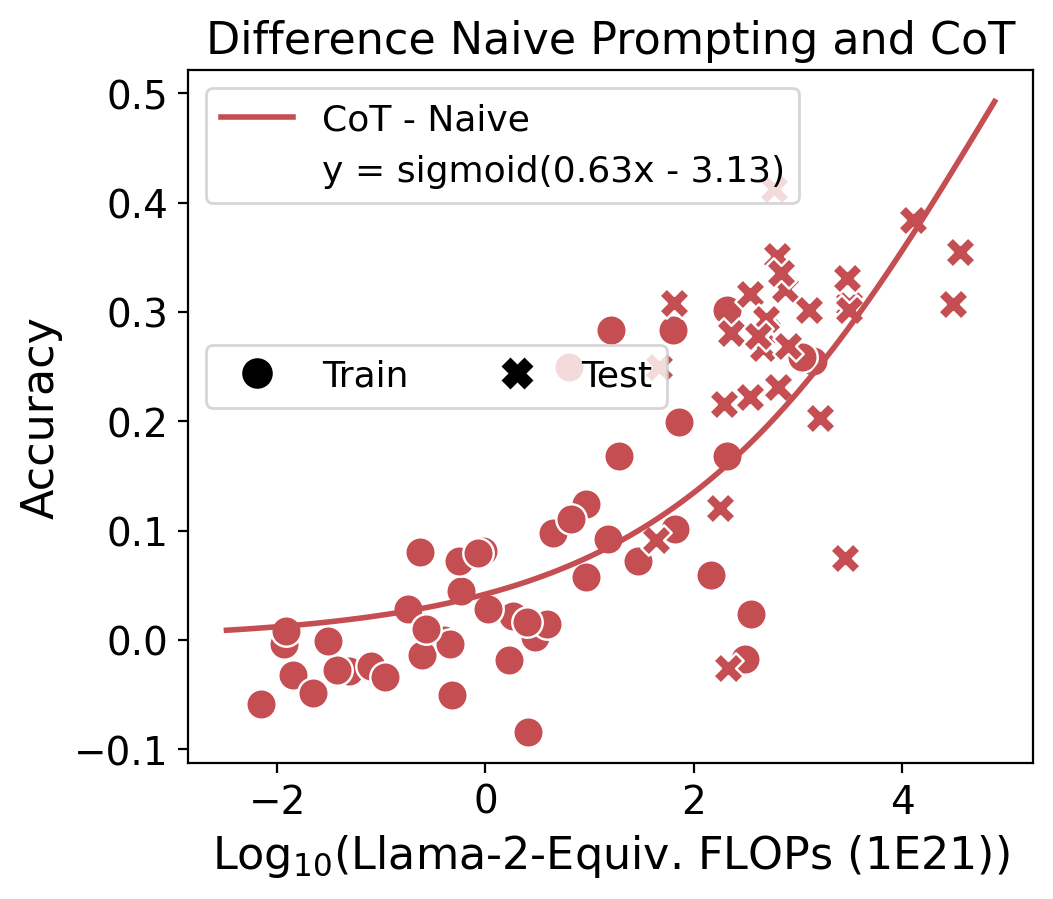

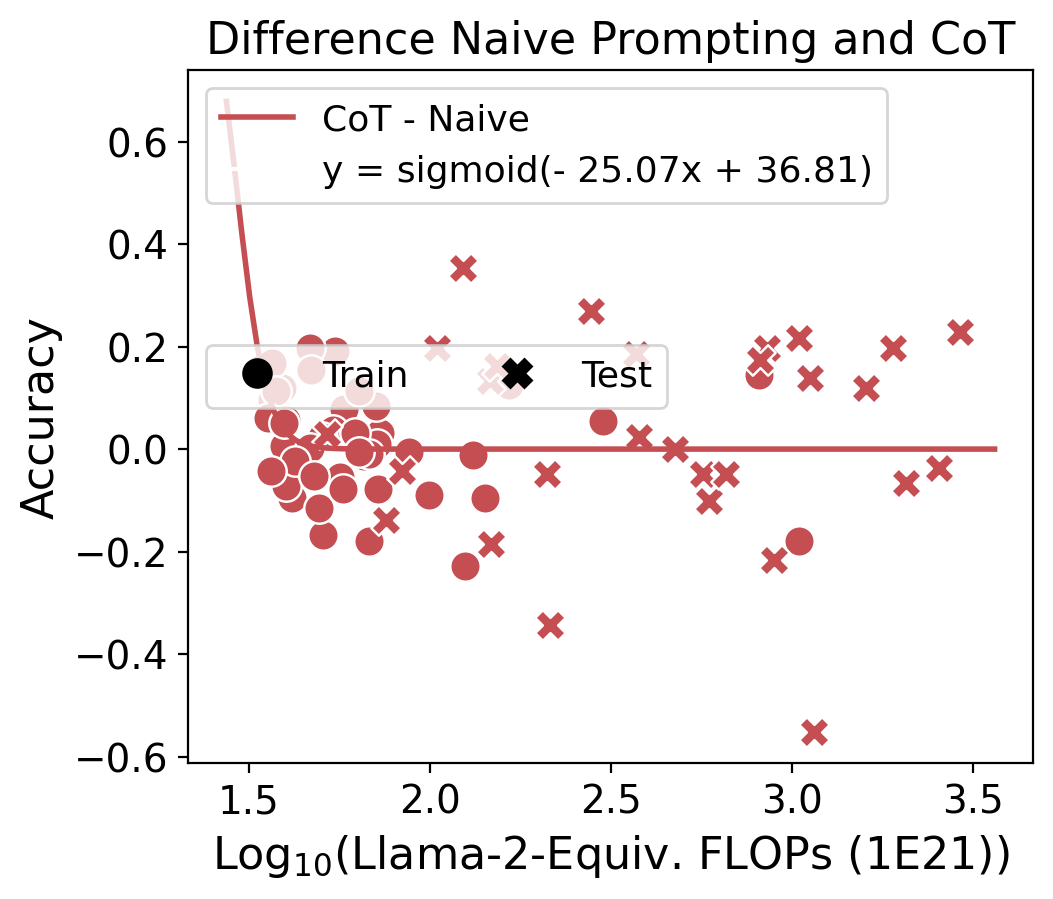

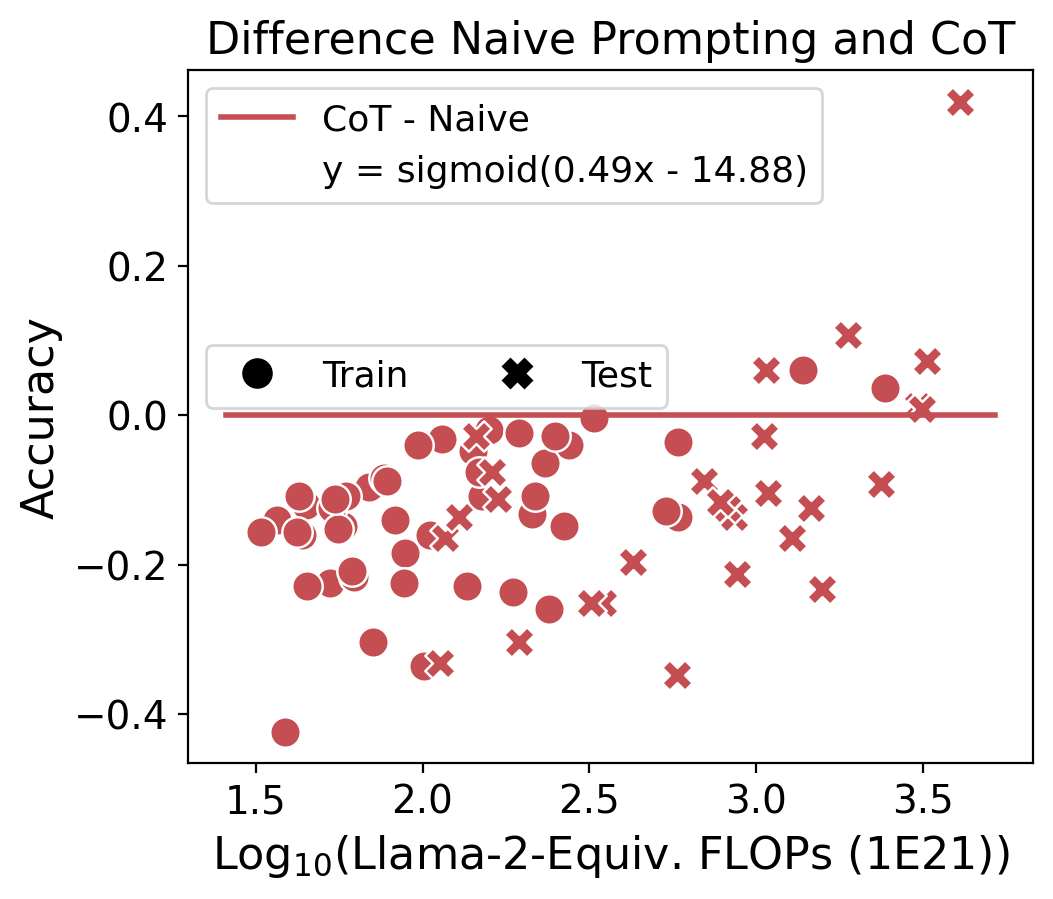

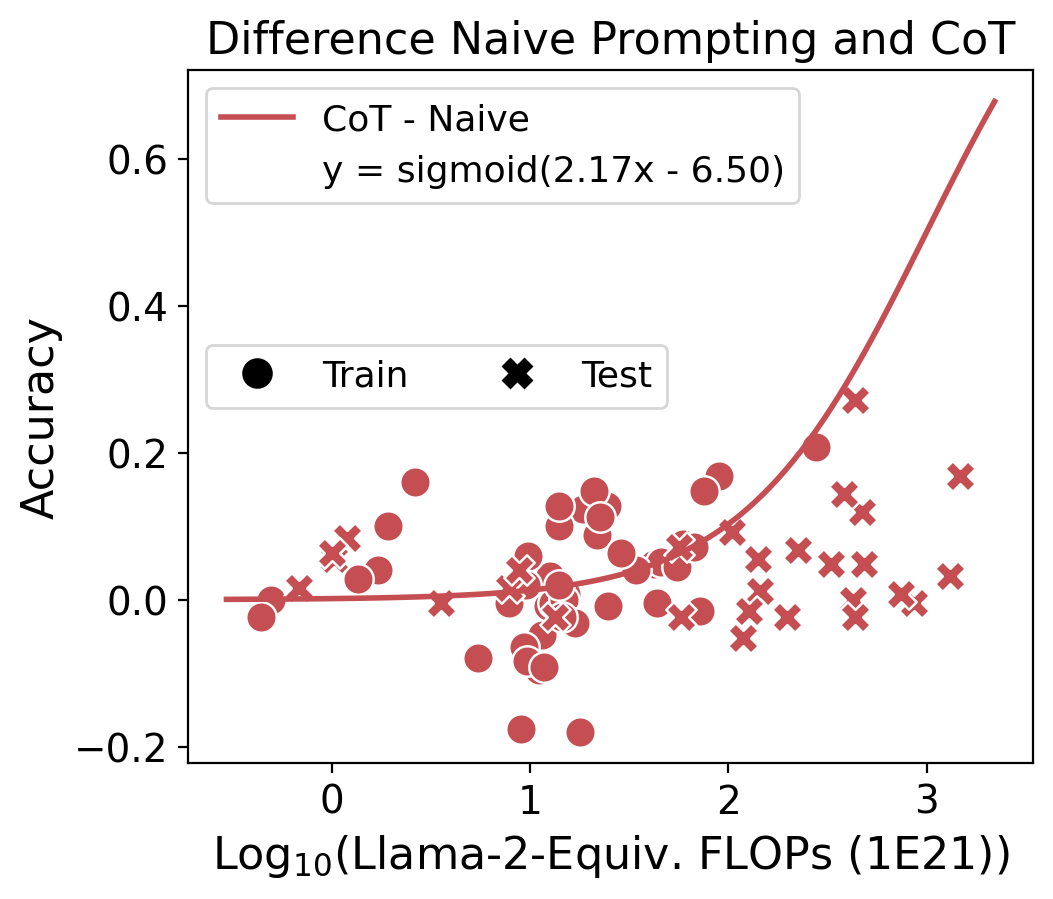

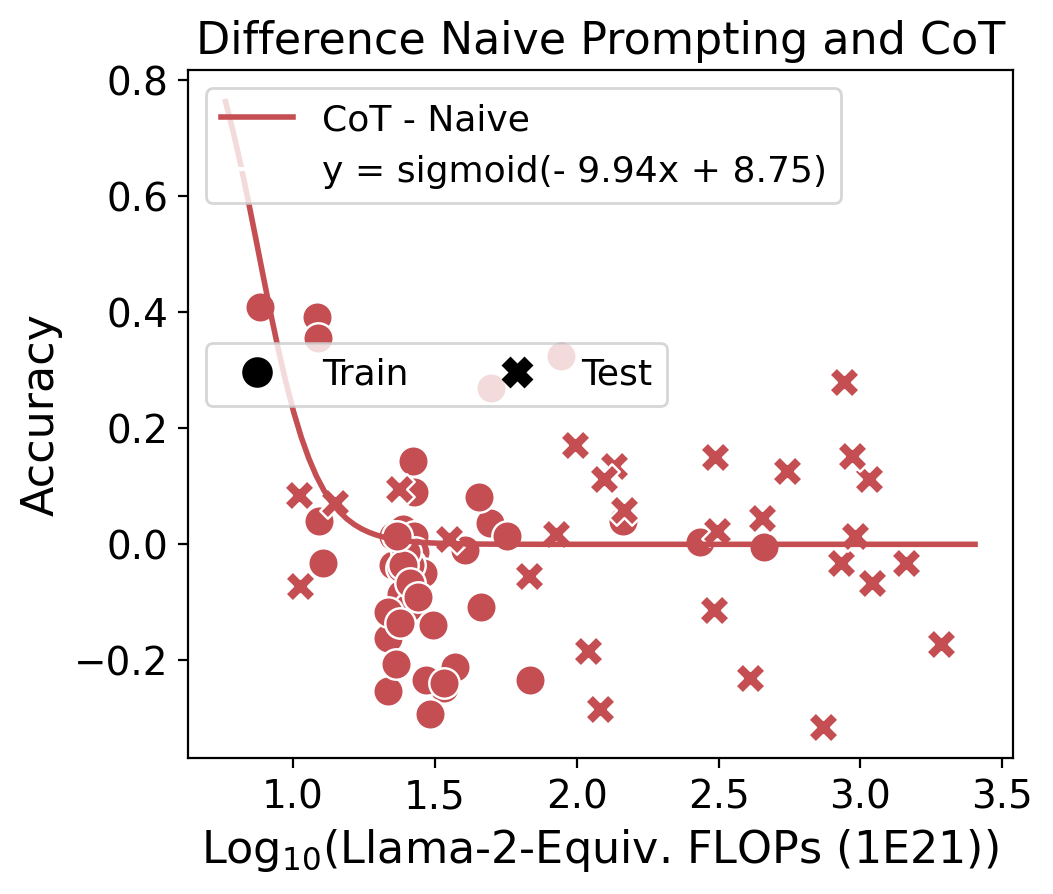

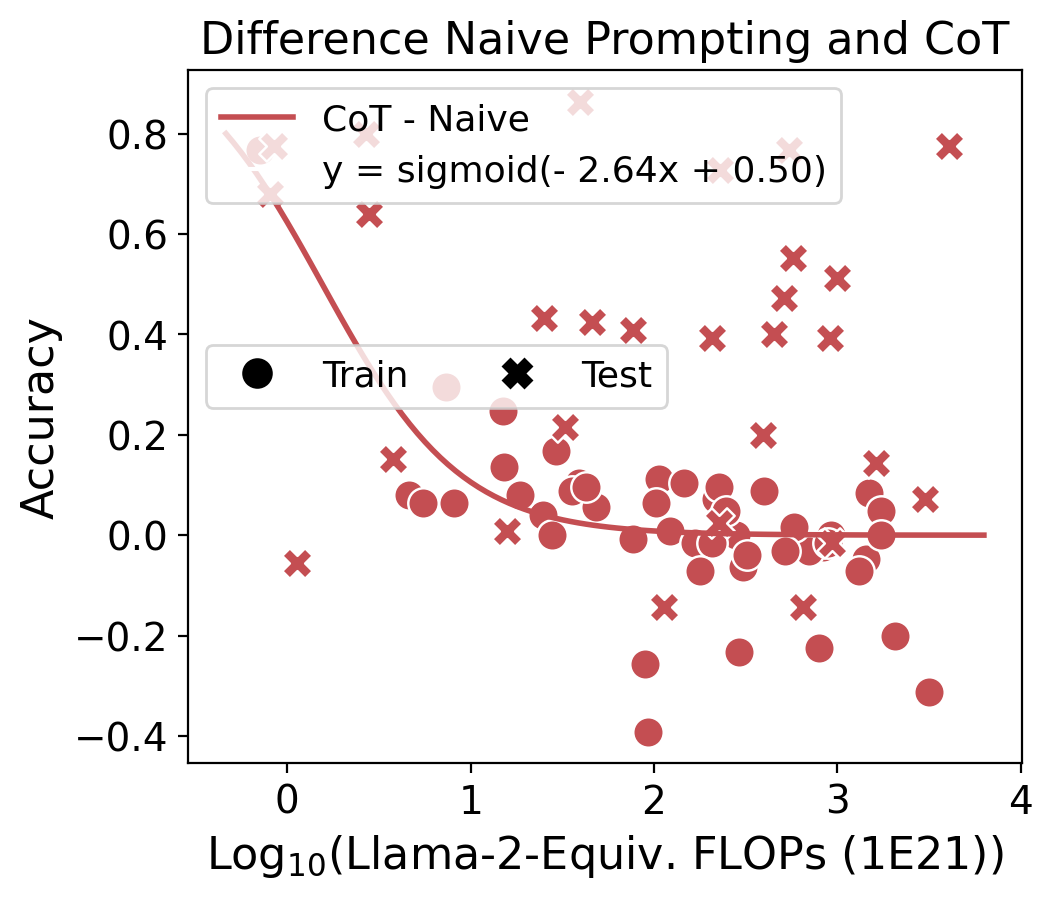

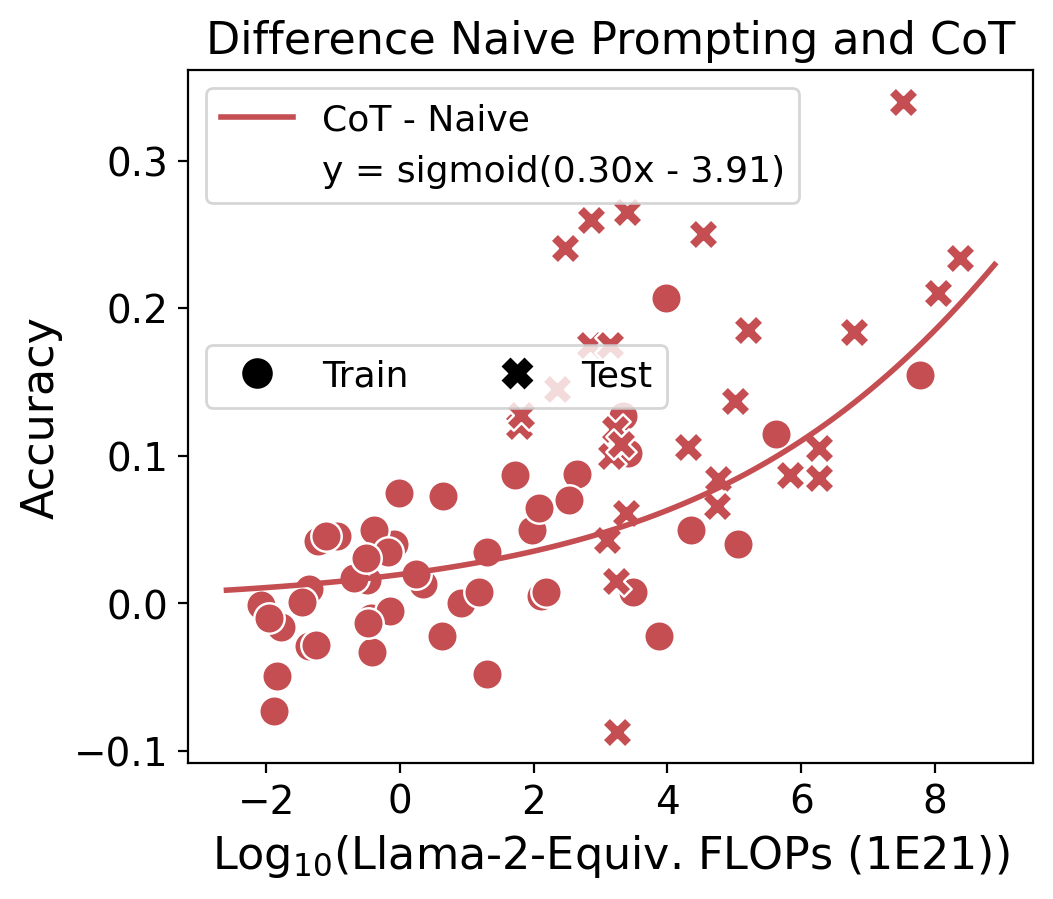

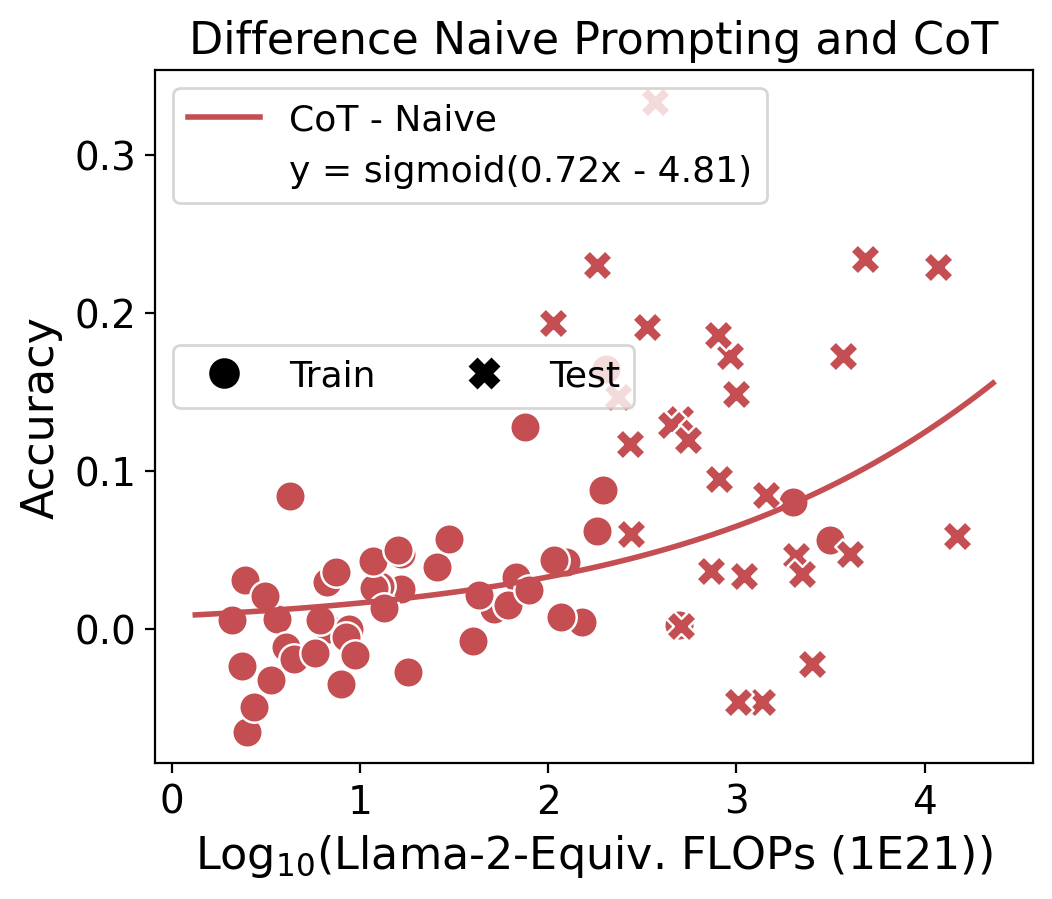

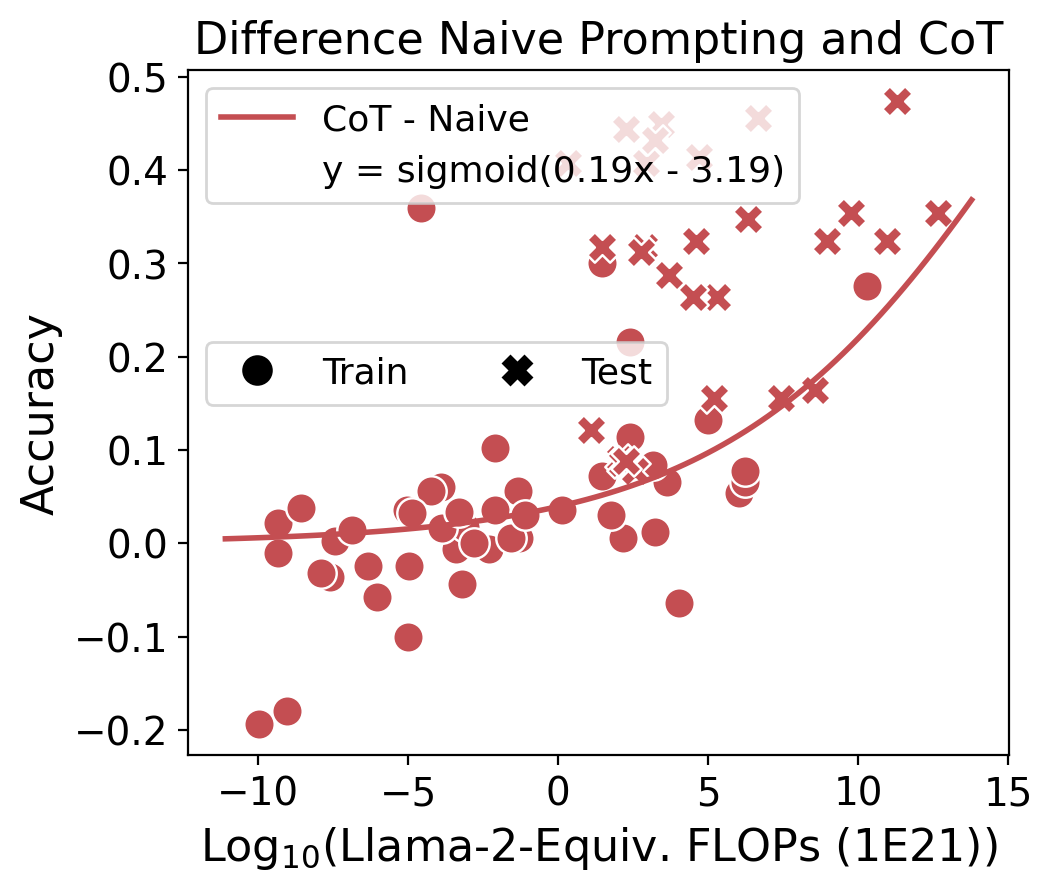

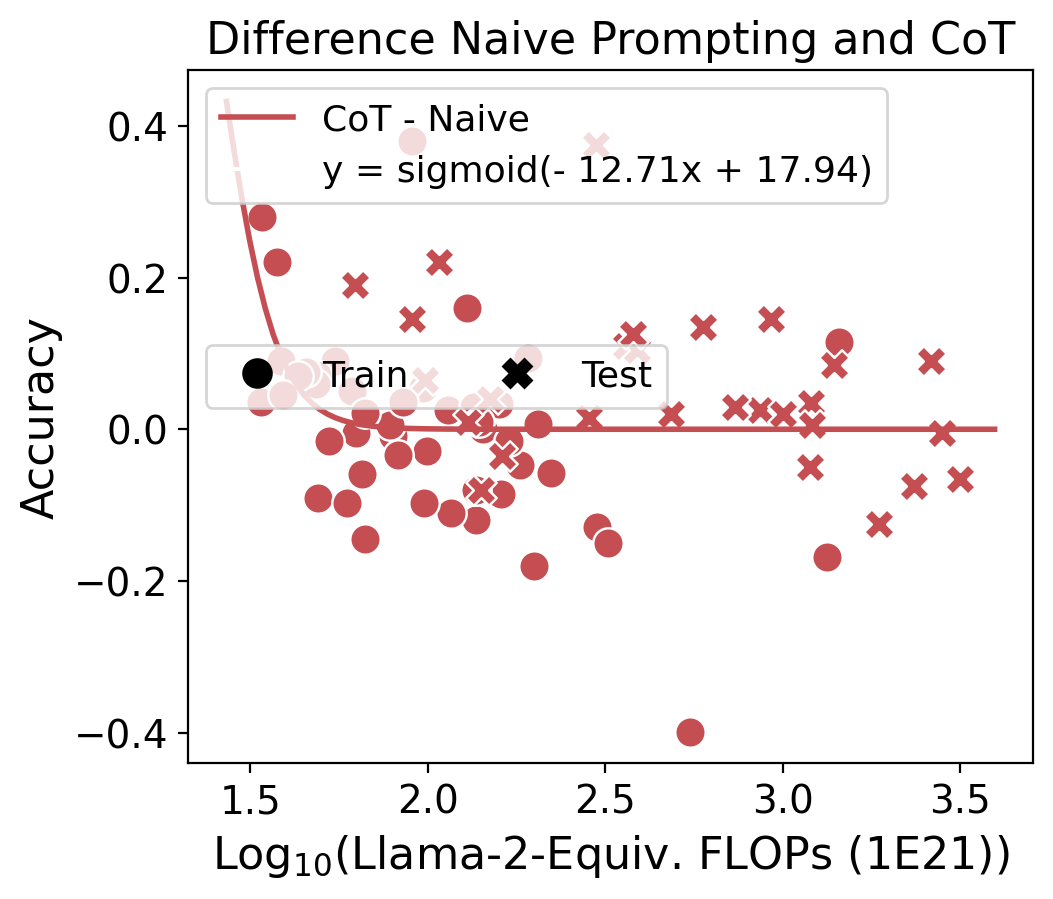

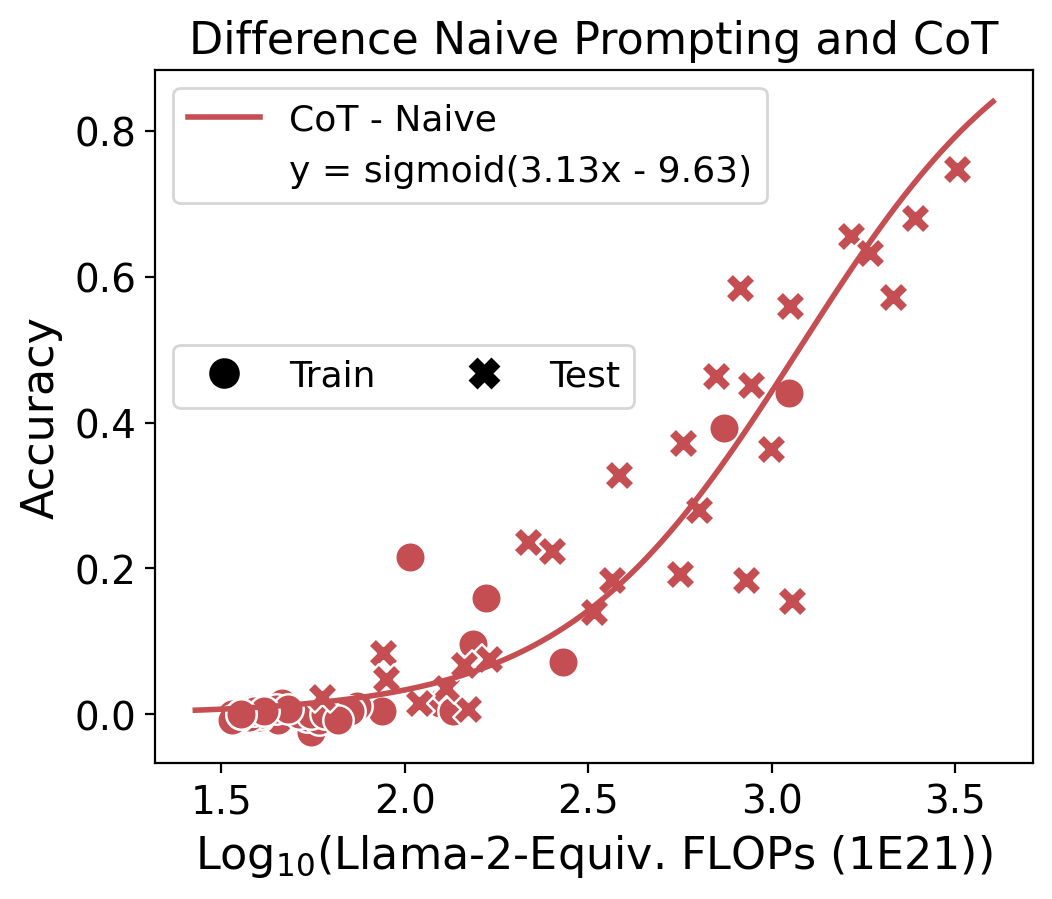

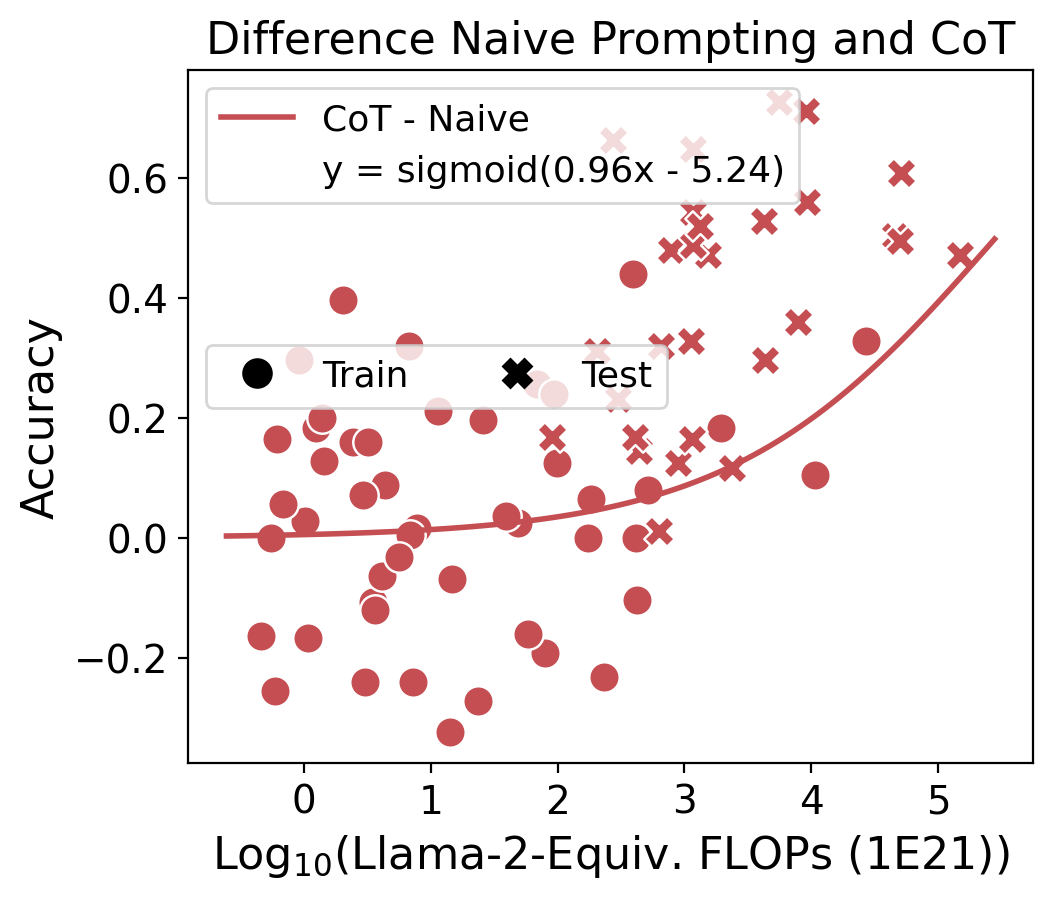

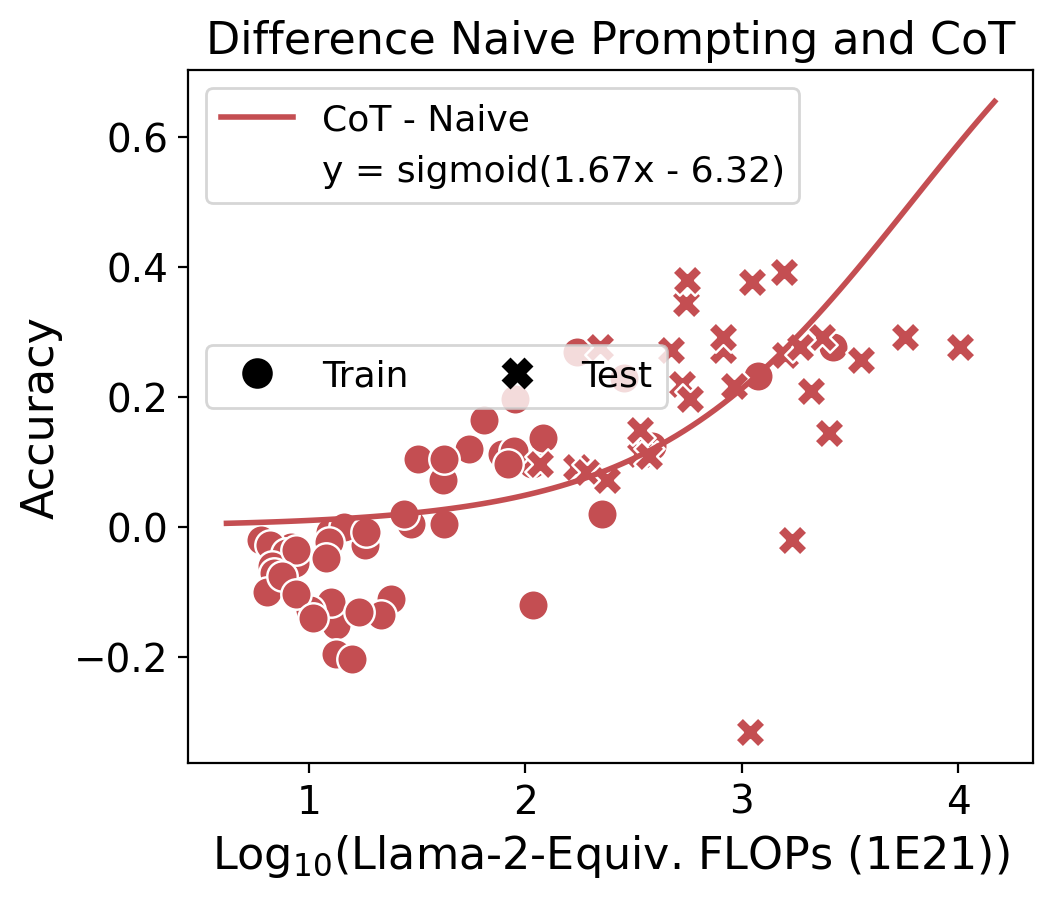

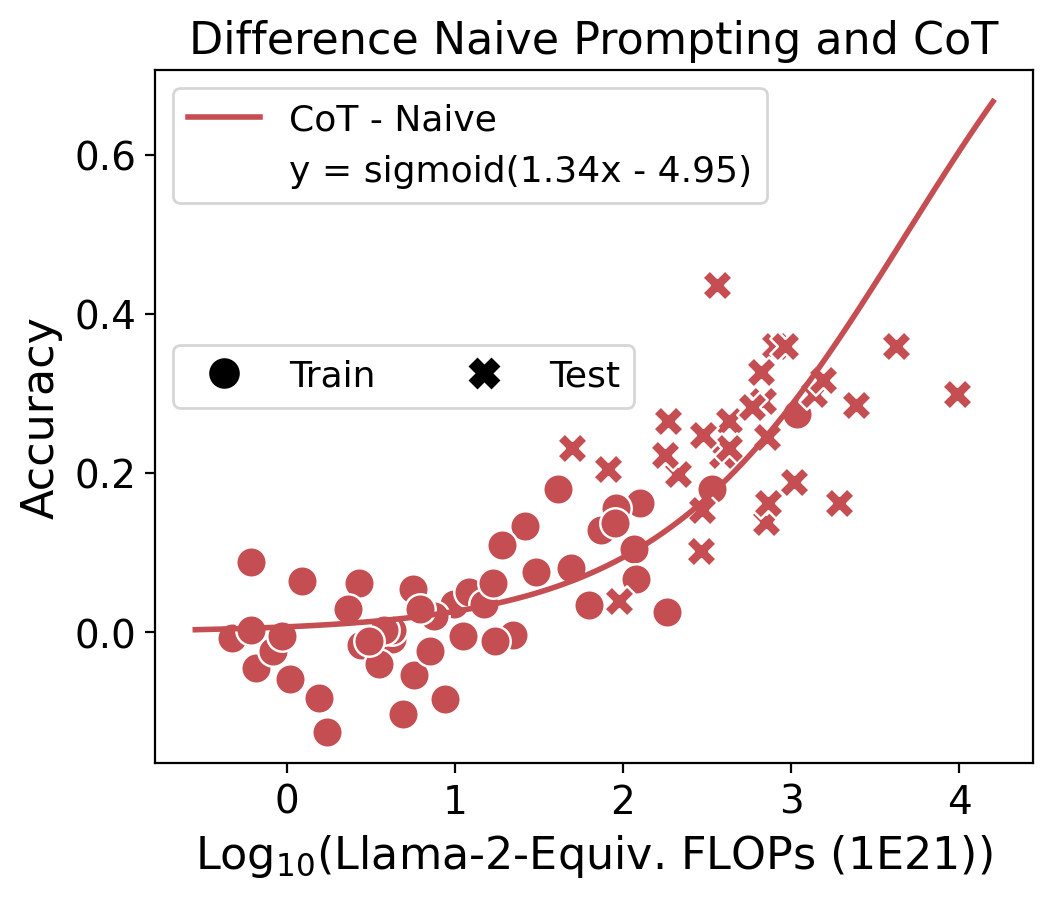

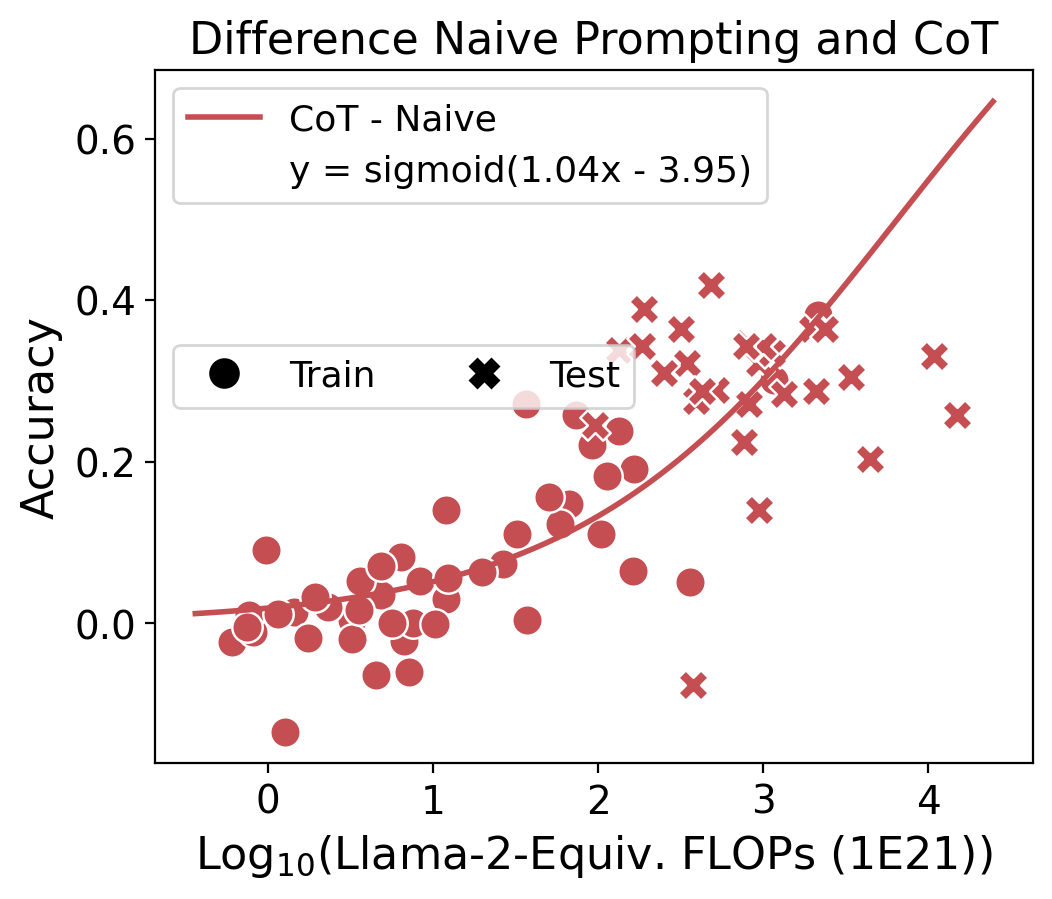

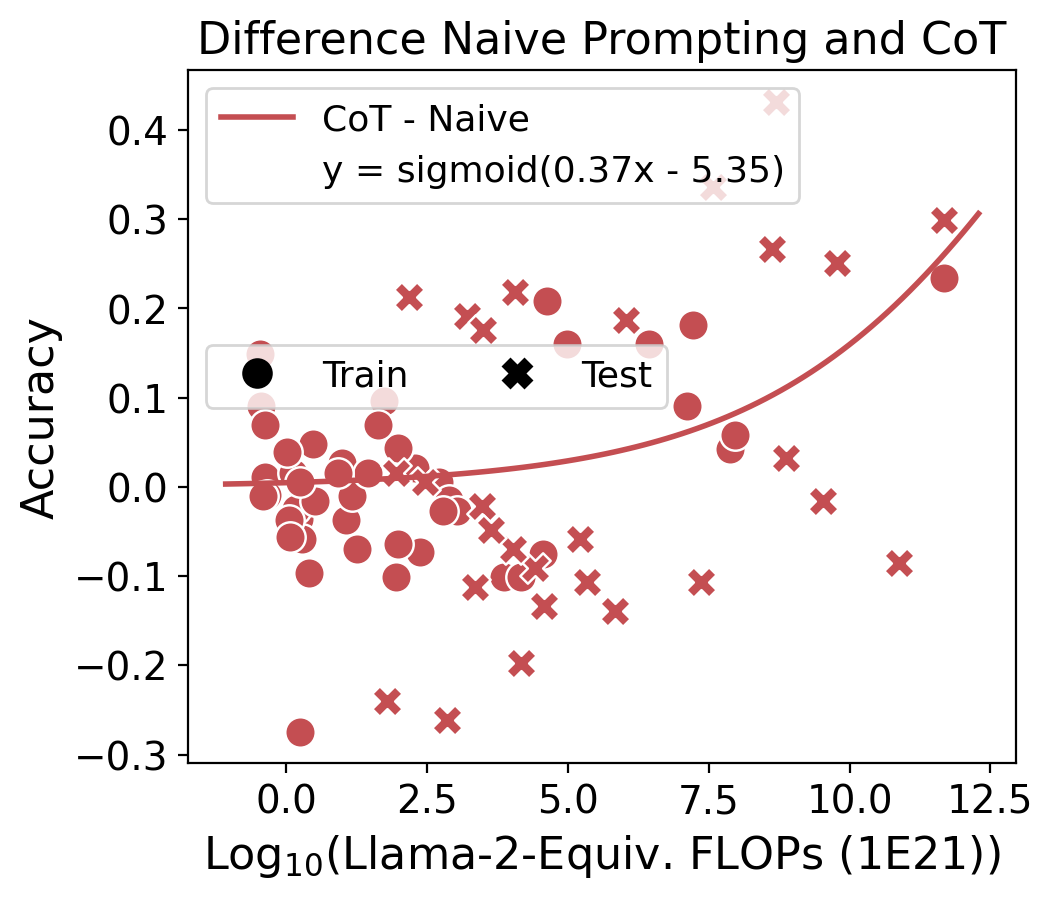

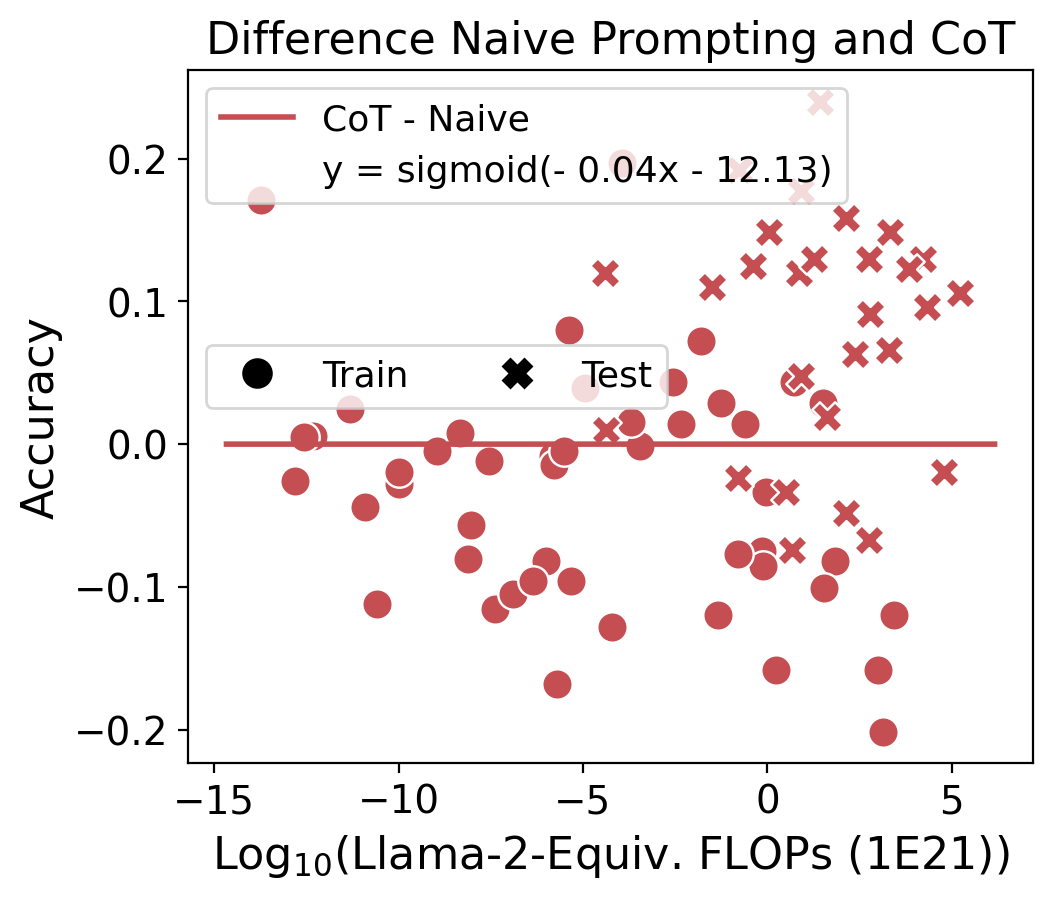

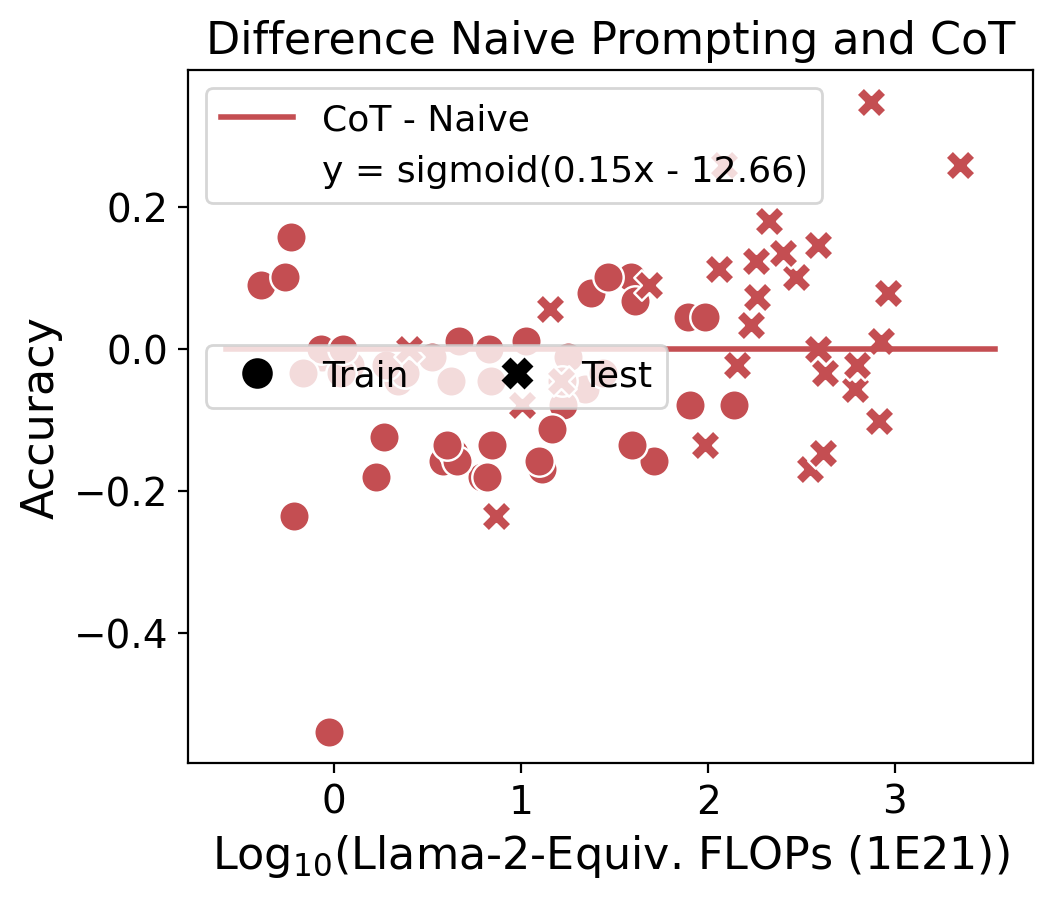

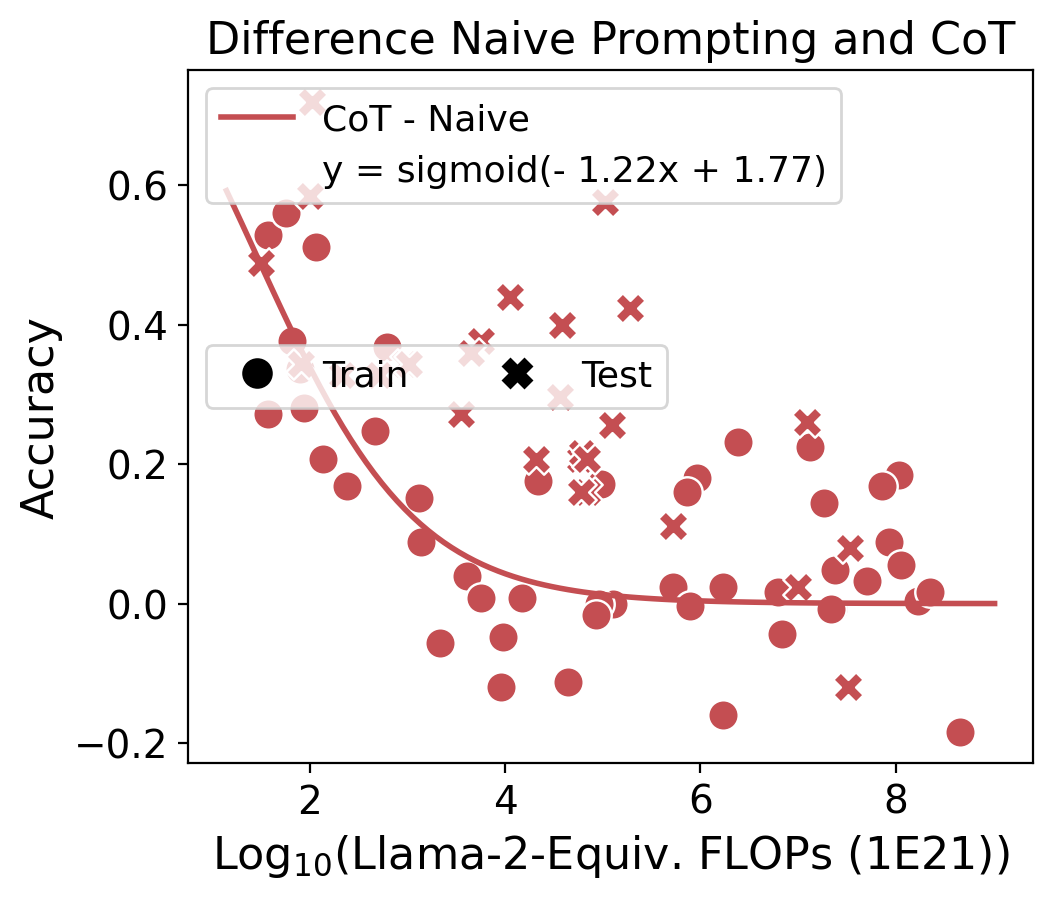

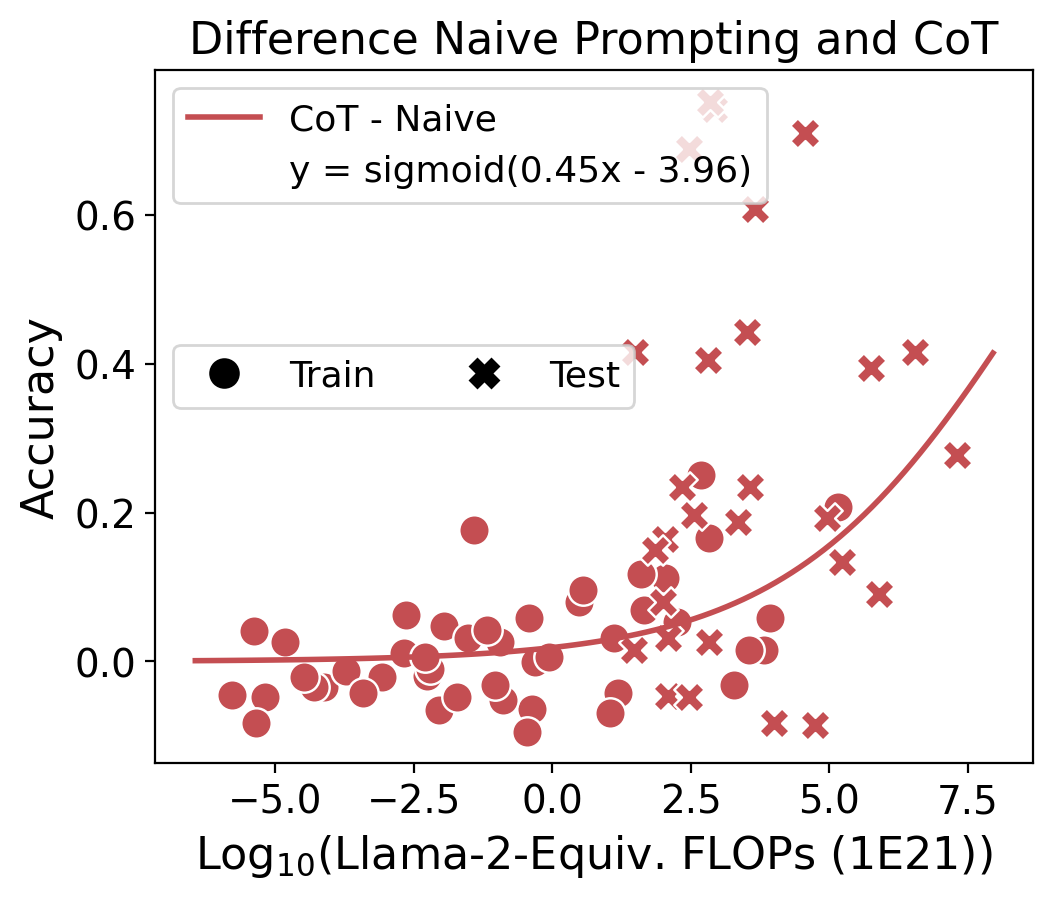

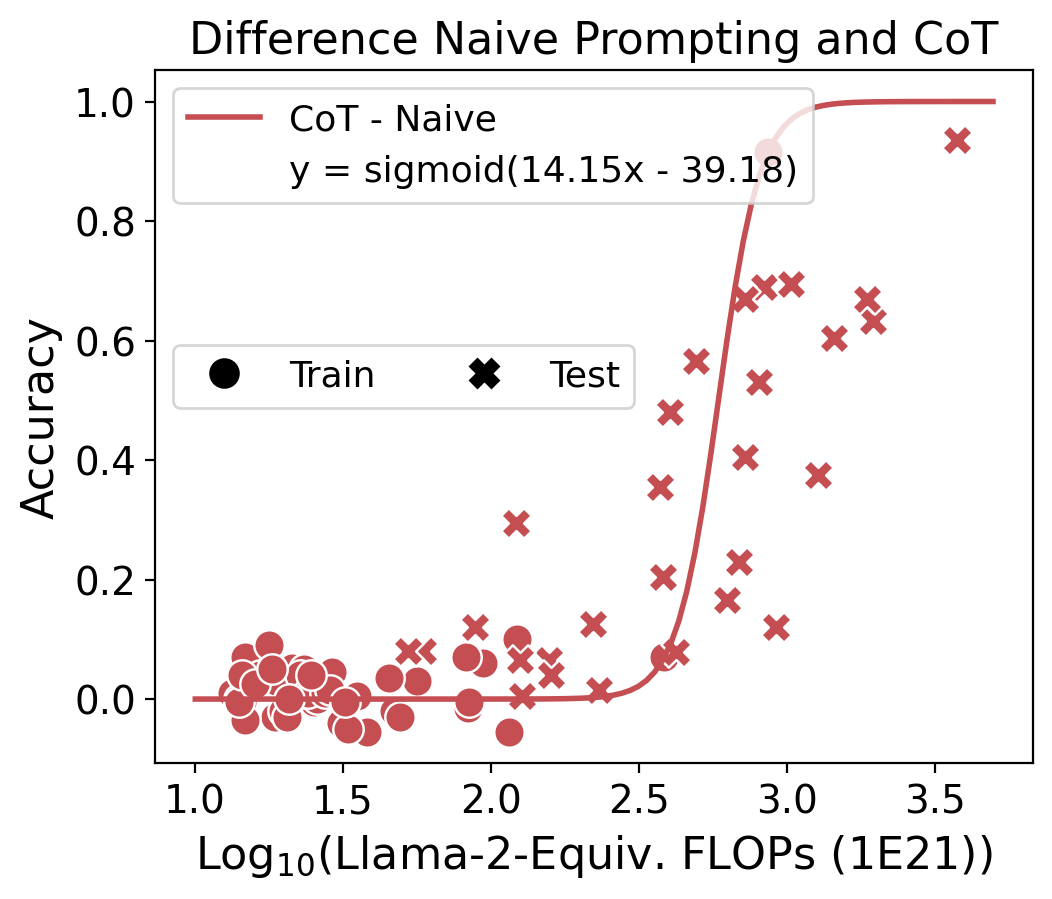

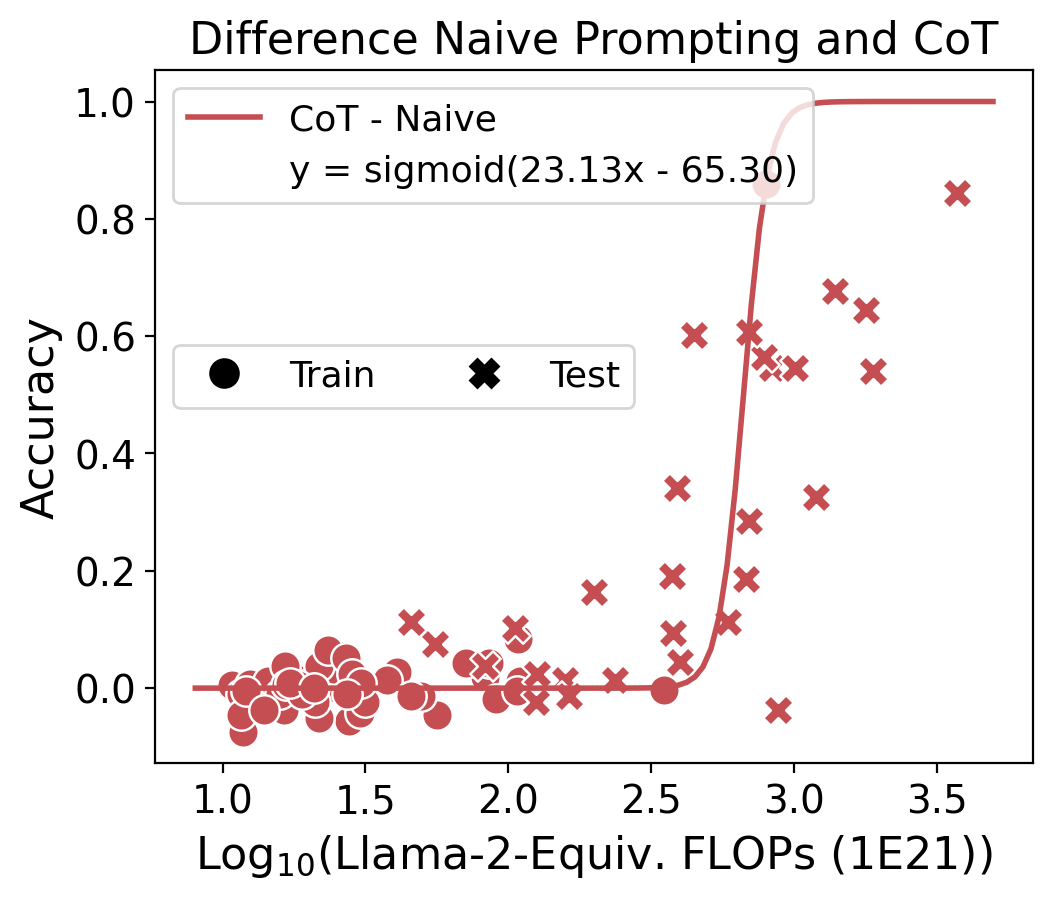

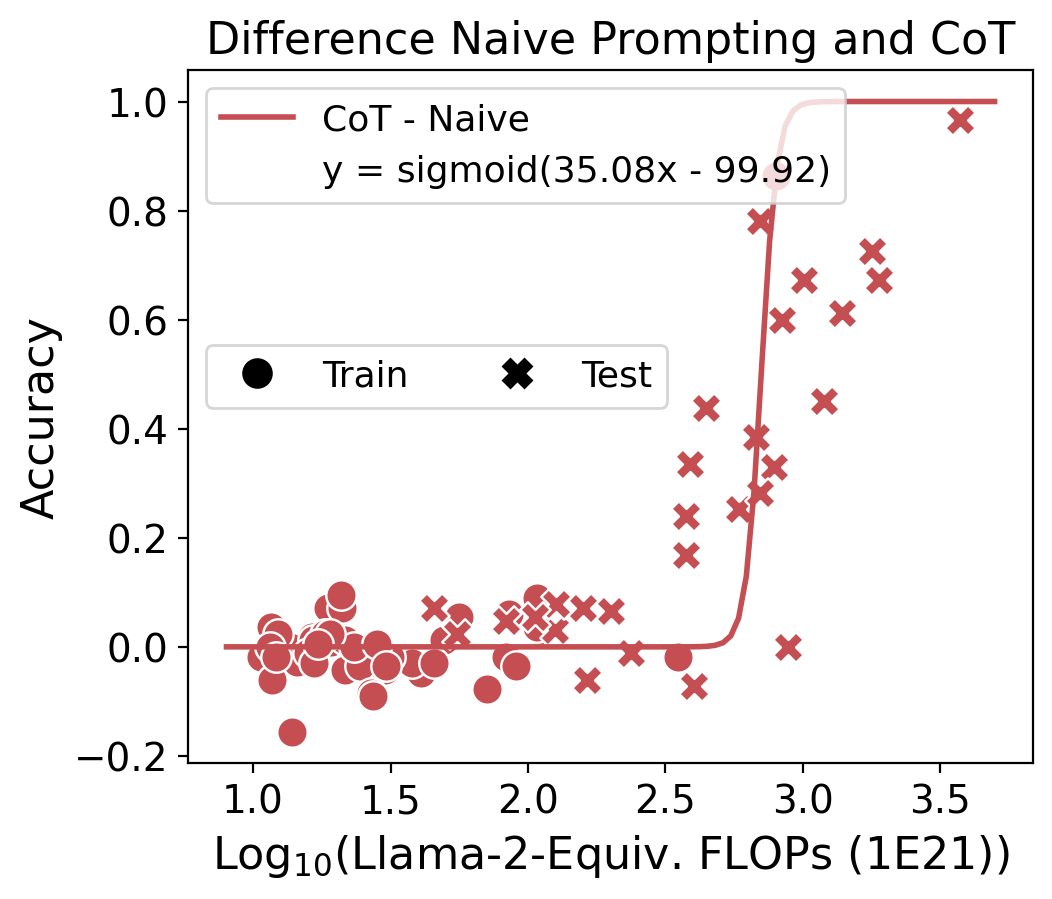

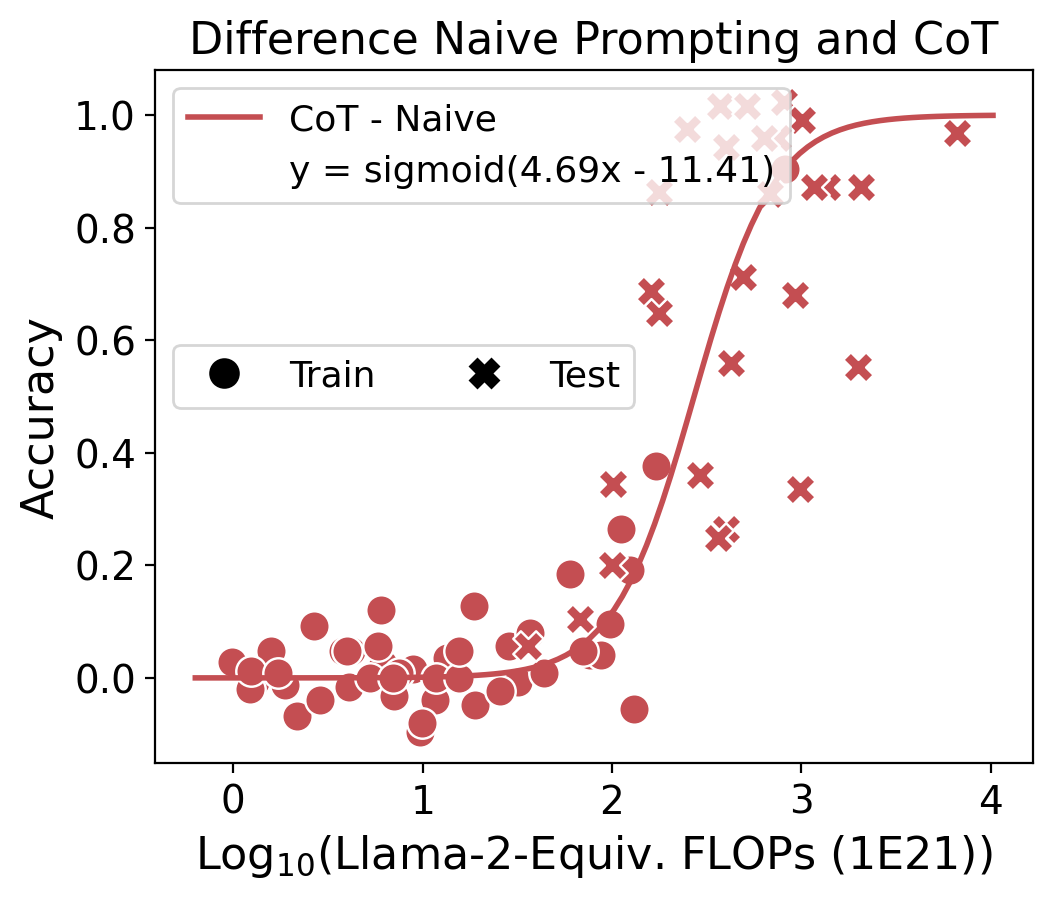

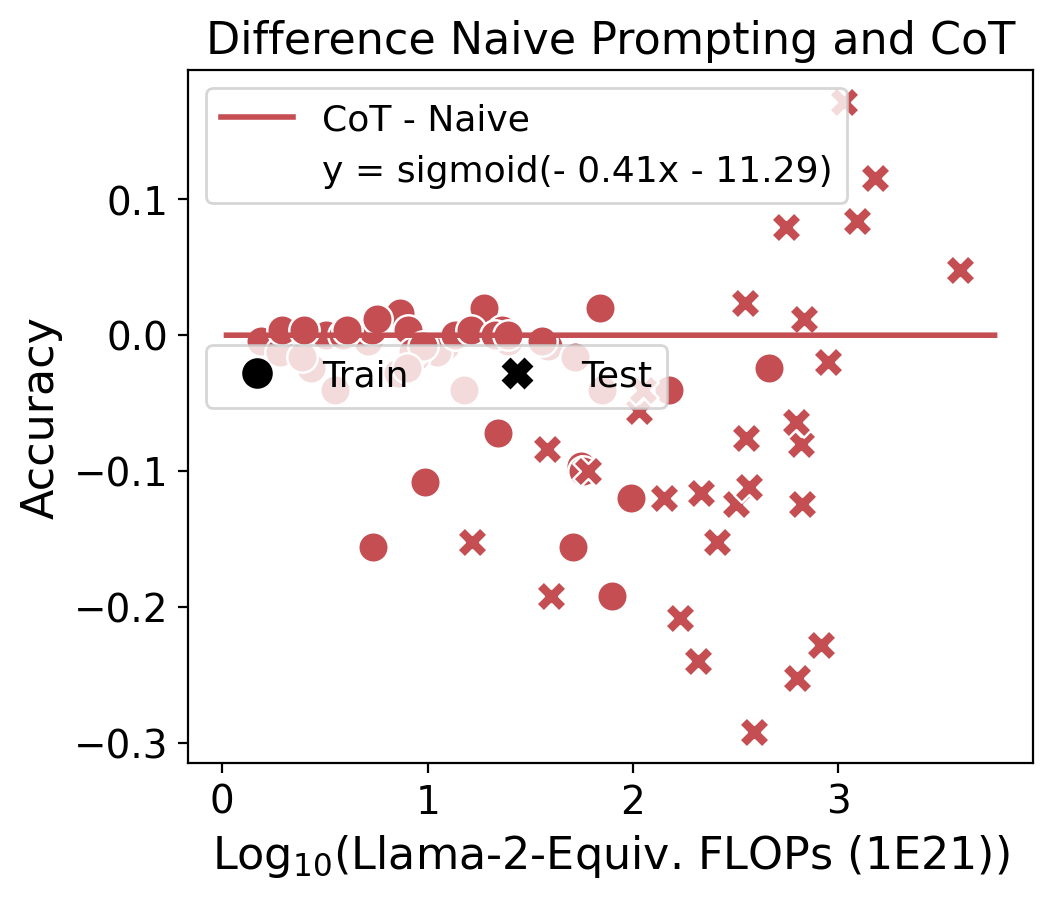

In [6]:
def plot_bbh_scaling_curves(task: str = "overall",
                            difference_cot_naive: bool = False):

    TASK = task
    BBH_PCA_PREPROCESS_KWARGS = DEFAULT_PCA_PREPROCESS_KWARGS.copy()
    BBH_PCA_PREPROCESS_KWARGS["imputation_metrics"] = ALL_BENCHMARK_METRIC_LIST
    BBH_PCA_PREPROCESS_KWARGS["pca_metrics"] = ALL_BENCHMARK_METRIC_LIST

    SCALING_SETUP_KWARGS = {
        # Data preprocessing: PCA imputation and extraction
        **BBH_PCA_PREPROCESS_KWARGS, 
        
        # Non-lineariy: sigmoid with parametrized scale and shift
        "nonlinearity": "sigmoid", 

        # Cutoff: 8.4E22 FLOPs corresponding to LLama-2 7B
        "split_method": "cutoff_by_FLOPs (1E21)",
        "cutoff_threshold": 84,

        # Model families: include all we have evaled
        "df_filter": lambda x: x['Model Family'].isin(EVAL_BASE_MODEL_FAMILIES),   
        "df_groupby": 'Model Family',  # group markers by model family

        # Regression: ordinary least squares
        "reg_method": "robust",  
        "reg_kwargs": {"delta": 1.0},  # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS
    }

    PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP = {
        f"bbh_fewshot_{TASK}_3_exact_match,flexible-extract,norm": "Naive - Greedy",
        f"bbh_cot_fewshot_{TASK}_3_exact_match,flexible-extract,norm": "CoT - Greedy",
    }
    
    PLOT_BBH_METHOD_SCALING_METRICS = list(PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP.keys())

    color_palette = sns.color_palette()

    PLOT_BBH_METHOD_SCALING_COLOR_MAP = {
        f'bbh_fewshot_{TASK}_3_exact_match,flexible-extract,norm': color_palette[1],
        f'bbh_cot_fewshot_{TASK}_3_exact_match,flexible-extract,norm': color_palette[0],
        'difference': color_palette[3],
    }

    PLOT_BBH_SETUP_SPECIFIC_KWARGS = {}
    for e in PLOT_BBH_METHOD_SCALING_METRICS:
        PLOT_BBH_SETUP_SPECIFIC_KWARGS[e] = {
            "plot_adjust_kwargs": {"title": PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP[e], "ylabel": "Accuracy"},
        }

    if not difference_cot_naive:
        fig, _ = plot_scaling_comparison_multi_metrics(
            base_llm_eval_with_post_training, 
            PLOT_BBH_METHOD_SCALING_METRICS, [PC_METRIC_NUM_3], SCALING_SETUP_KWARGS, 
            y_metric_specific_kwargs=PLOT_BBH_SETUP_SPECIFIC_KWARGS,
            ymetric2title_map=PLOT_BBH_METHOD_SCALING_ORIG_METRIC_MAP, ymetric2color_map=PLOT_BBH_METHOD_SCALING_COLOR_MAP,
            plot_title="CoT"
        )
        fig.savefig(f'/scratch2/jsalle/ObsScaling/notebooks/figures/curves/bbh_{task}.png')

    else:
        PLOT_BBH_METHOD_SCALING_METRICS.reverse()
        metric_for_difference = PLOT_BBH_METHOD_SCALING_METRICS
        
        fig, _ = plot_scaling_comparison_multi_metrics(
            base_llm_eval_with_post_training, 
            y_metric_list=['difference'], 
            metrics_for_difference=metric_for_difference,
            x_metrics_list=[PC_METRIC_NUM_3], 
            analysis_setup_kwargs=SCALING_SETUP_KWARGS, 
            y_metric_specific_kwargs=GSM8K_SETUP_SPECIFIC_KWARGS,
            ymetric2title_map=GSM8K_METHOD_SCALING_ORIG_METRIC_MAP, 
            ymetric2color_map=GSM8K_METHOD_SCALING_COLOR_MAP,
            plot_title="Difference Naive Prompting and CoT"
        )
        fig.savefig(f'/scratch2/jsalle/ObsScaling/notebooks/figures/curves/bbh_differencecotnaive_{task}.png')

    return


for task in BBH_SUBTASKS:
    plot_bbh_scaling_curves(task=task,
                            difference_cot_naive=True)


## Weights Analysis

In [ ]:
mmlu_df = load_acc_mmlu_subtasks()
mmlu_subtasks = [t for t in mmlu_df.columns if t != 'Model']


for task in BBH_SUBTASKS:

    scaling1, analysis_setup, setup_specific_kwargs, orig_metric_map, color_map = get_bbh_subtask_scaling_metrics(task=task,
                                                                                                                  mmlu_subtasks=mmlu_subtasks)


    fig = plot_weight_analysis(
        merged_eval, 
        y_metrics=scaling1, 
        x_metrics_list=[PC_METRIC_NUM_2], 
        analysis_setup_kwargs=analysis_setup, 
        y_metric_specific_kwargs=setup_specific_kwargs, 
        #filter_model_family=EVAL_BASE_MODEL_FAMILIES, # not default
        norm_weights=False,
        remove_y_ticks=False,
        figsize=14,
        rotationx=90,
        cmap='coolwarm',
        v=15,
        task=task
    )
    #plt.tight_layout()
    fig.savefig(f'/scratch2/jsalle/ObsScaling/notebooks/figures/weights/weights_bbh_{task}.png')

AttributeError: 'str' object has no attribute 'items'